In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoFeatureExtractor, AutoTokenizer, ClapModel
import torchaudio

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Initialize model
model = ClapModel.from_pretrained("laion/clap-htsat-unfused")
tokenizer = AutoTokenizer.from_pretrained("laion/clap-htsat-unfused")
feature_extractor = AutoFeatureExtractor.from_pretrained("laion/clap-htsat-unfused")            

model.to(device)

def get_clap_emb(input_type, file_path):

    if input_type == 1:
        
        audio_sample, sr = torchaudio.load(file_path)
        audio_sample = torchaudio.functional.resample(audio_sample, orig_freq=sr, new_freq=48000)[0]
        inputs = feature_extractor(audio_sample, sampling_rate=48000, return_tensors="pt").to(device)
        audio_features = model.get_audio_features(**inputs)
        return audio_features
    
    elif input_type == 3:
        inputs = tokenizer([file_path], padding=True, return_tensors="pt").to(device)
        text_features = model.get_text_features(**inputs)
    
        return text_features

/home/alberto/anaconda3/envs/imgbind/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# input_type = int(input('1 - audio\n2 - image\n3 - text'))
# file_path = input('File path/text prompt: ')
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

data_path = '5_speakers_p'

files = []
points = []
colors = []

for i, speaker in enumerate([os.path.join(data_path, f) for f in os.listdir(data_path)]):

    speaker_name = speaker.split('/')[-1]

    for file_path in tqdm([os.path.join(speaker, k) for k in os.listdir(speaker)]):

        input_type = 1
        emb = get_clap_emb(input_type, file_path)

        points.append(emb.cpu().detach().numpy()[0])
        colors.append(i)
        files.append(speaker_name + '_' + file_path.split('/')[-1])

points = np.array(points)
colors = np.array(colors)

print(points.shape, colors.shape)


100%|██████████| 300/300 [01:58<00:00,  2.53it/s]

(1500, 512) (1500,)


In [3]:
tsne = TSNE(n_components=2, perplexity=50, init='pca', random_state=0)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(points)
X_tsne = tsne.fit_transform(points)

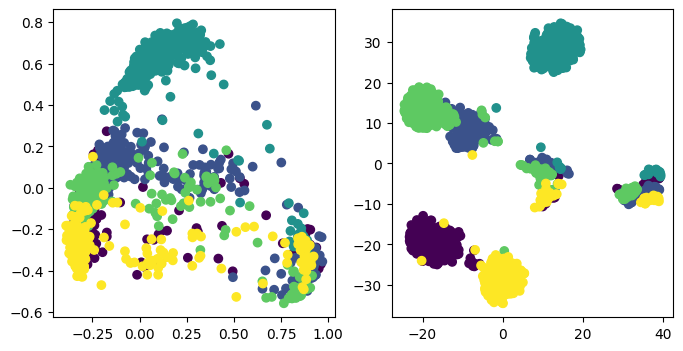

In [4]:

def plot_emb(ax, X, colors, names):
    # plot data
    ax.scatter(X[:, 0], X[:, 1], c=colors)
    # for i, txt in enumerate(names):
    #     plt.annotate(txt, (X[i, 0], X[i, 1]), fontsize=8, xytext=(2, 2), textcoords='offset points')
        
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plot_emb(axes[0], X_pca, colors, files)
plot_emb(axes[1], X_tsne, colors, files)
plt.show()